# MPhil DIS: S1 Coursework 2025/26

*Your Name (crsid@cam.ac.uk)*

## The Problem

Your college room mate is a Physics student having some trouble with data analysis. 

They have been asked by their supervisor to determine the performance of a photon detector in their lab. 

Your friend has diligently collected calibration samples in the lab. They have used a laser setup to produce single photons at known fixed Energies (i.e. frequencies) of $E_0$ = [20, 30, 40, 50, 60, 70, 80] GeV and recorded the measured energy, $E$, of the detector (also in GeV, although the units are irrelevant for this problem). They performed $N=1000$ measurements of the energy recorded by the detector, $E$, at each fixed point $E_0$. (Hint: we may assume the supervisor's lab setup is so sophisticated that the energy uncertainty of the laser itself is negligible - in other words $E_0$ is known exactly with no error). 

Your friend knows, because they asked ChatGPT, that the measured energy (registered by the detection device),
$E$, will be normally distributed, $E\sim \mathcal{N}(\mu_E, \sigma^2_E)$, with mean, 

$$
\mu_E = \lambda E_0 + \Delta,
$$

and a width, $\sigma_E$, given by

$$
\left( \frac{\sigma_E}{E_0} \right)^2 = \left( \frac{a}{\sqrt{E_0}} \right)^2 + \left( \frac{b}{E_0} \right)^2 + c^2.
$$

Your task is to use the input data provided in `sample.csv` (which contains two columns corresponding to the laser energy, $E_0$, and the measured energy, $E$) to provide estimates of the parameters $\{ \lambda, \Delta, a, b, c\}$

In [1]:
# --- Autoreload for development ---
%load_ext autoreload
%autoreload 2

# --- Standard imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Project module imports ---
from s1_sol.data_loader import load_sample_data, get_residuals, get_residuals_by_energy
from s1_sol.statistics import compute_sample_stats, fit_mean_model_least_squares, fit_width_model_least_squares
from s1_sol.models import mean_energy_model, width_energy_model, relative_width_squared
from s1_sol.fitting import fit_normal_mle, fit_individual_energies, fit_simultaneous_all_energies
from s1_sol.plotting import (setup_plot_style, plot_residuals_total, plot_residuals_by_energy, 
                              plot_sample_statistics, bootstrap_fit_results, 
                              plot_rescaled_with_fits_and_bands, plot_individual_fits_overlaid)
from s1_sol.bootstrap import bootstrap_sample, run_bootstrap_analysis, compute_bootstrap_confidence_interval
from s1_sol.results_manager import ResultsManager

# --- Plot styling ---
setup_plot_style()

# --- Ensure figs/ directory exists ---
os.makedirs('../figs', exist_ok=True)

# --- Initialize results manager ---
results = ResultsManager()

print("All imports successful!")

All imports successful!


In [2]:
# Load the calibration sample
df, data_dict, e0_values = load_sample_data('../sample.csv')

print(f"Loaded {len(df)} total measurements")
print(f"Energy points: {e0_values}")
print(f"\nMeasurements per energy point:")
for e0 in e0_values:
    print(f"  E0 = {e0} GeV: {len(data_dict[e0])} measurements")

# Display first few rows
df.head(10)

Loaded 7000 total measurements
Energy points: [20 30 40 50 60 70 80]

Measurements per energy point:
  E0 = 20 GeV: 1000 measurements
  E0 = 30 GeV: 1000 measurements
  E0 = 40 GeV: 1000 measurements
  E0 = 50 GeV: 1000 measurements
  E0 = 60 GeV: 1000 measurements
  E0 = 70 GeV: 1000 measurements
  E0 = 80 GeV: 1000 measurements


,E_true,E_rec
0,20,23.240306
1,20,22.919144
2,20,22.172158
3,20,24.270106
4,20,22.491233
5,20,23.136427
6,20,26.423902
7,20,24.343425
8,20,18.820742
9,20,23.398703


## 1) Plotting Sample Estimates
**10 marks**

### 1(i) plot total sample
- Plot of the measured energy, `E`, minus the true energy, `E_0`. Saved in `figs/Figure1.1.pdf`.

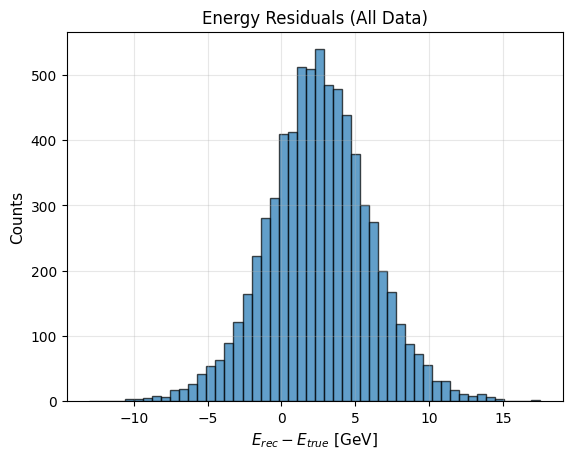

Figure 1.1 saved.


In [3]:
fig, ax = plot_residuals_total(df)
fig.savefig('../figs/Figure1.1.pdf')
plt.show()

print("Figure 1.1 saved.")

### 1(ii) overlay samples at each $E_0$
- Make a plot which shows the distribution of `E - E_0`, with the histograms for each different value of `E_0` overlaid. This plot should be saved in `figs/Figure1.2.pdf`

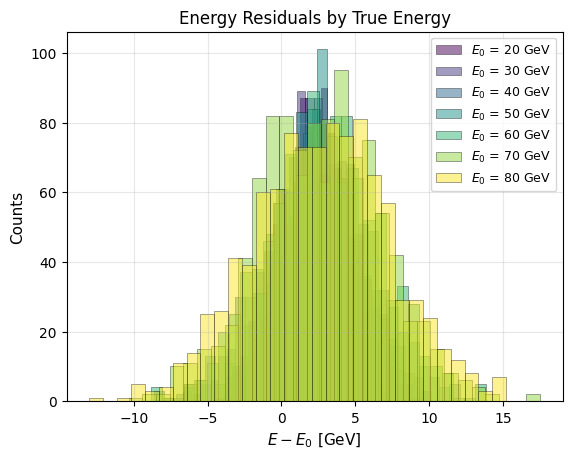

Figure 1.2 saved.


In [4]:
fig, ax = plot_residuals_by_energy(data_dict)
fig.savefig('../figs/Figure1.2.pdf')
plt.show()

print("Figure 1.2 saved.")

### 1(iii) sample estimates
- Produce sample estimates of the mean, $\hat{\mu}_{\rm samp}$, and standard deviation, $\hat{\sigma}_{\rm samp}$, of $E$ at each value of $E_0$. These should be presented along with sample estimates of the error on these estimates (i.e. the standard error on the mean and the standard error on the standard deviation).
- Make two plots (sub-axes of the same figure) showing the points $\hat{\mu}_{\rm samp}$ and $\hat{\sigma}_{\rm samp}$ as a function of $E_0$. This figure should be saved to `figs/Figure1.3.pdf`

In [5]:
# sample statistics
stats_df = compute_sample_stats(data_dict)

print("Sample Statistics:")
print(stats_df.to_string(index=False))

Sample Statistics:
 E0      mean  mean_err      std  std_err    n
 20 22.264506  0.071879 2.273015 0.050852 1000
 30 32.316381  0.082017 2.593617 0.058024 1000
 40 42.350116  0.095379 3.016142 0.067477 1000
 50 52.596214  0.108588 3.433840 0.076821 1000
 60 62.796430  0.120120 3.798533 0.084980 1000
 70 72.609270  0.131703 4.164815 0.093175 1000
 80 82.685761  0.146592 4.635636 0.103708 1000


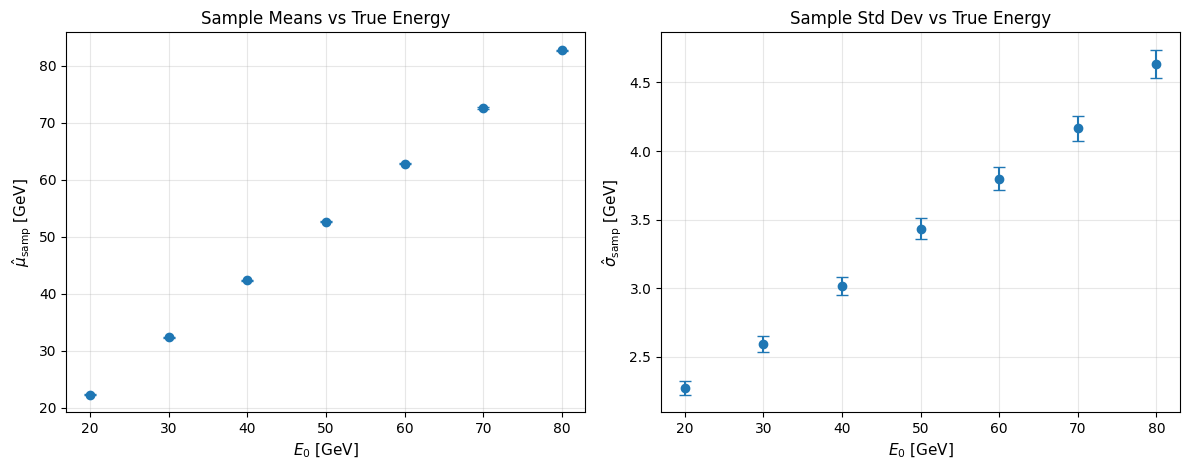

Figure 1.3 saved.


In [6]:
stats_df = compute_sample_stats(data_dict)
fig, ax = plot_sample_statistics(stats_df, savepath='../figs/Figure1.3.pdf')
plt.show()

print("Figure 1.3 saved.")


### 1(iv) fit trends
- Perform a least squares fit using the energy and width dependence formulas provided in the problem description (at the top of this notebook) to produce estimates (and estimates of the errors on those estimates) for the parameters $\lambda$, $\Delta$, $a$, $b$ and $c$. Be sure to save these determinations for later or write them directly into the `results.json` file
- The previously made plots don't have a particular sensible y-scale. Make two plots (sub-axes of the same figure) showing the points $\hat{\mu}_{\rm samp}$ and $\hat{\sigma}_{\rm samp}$ as a function of $E_0$ **but this time realign the y-scale** so that you plot $\hat{\mu}_{\rm samp} - E_0$ and $\hat{\sigma}_{\rm samp} / E_0$. You should also **overlay the fitted curves** and add error bands ($\pm 1\sigma$) to the curves by bootstrapping. This figure should be saved to `figs/Figure1.4.pdf`

In [7]:
# --- Fit mean model: μ_E = λ·E₀ + Δ ---
lambda_samp, delta_samp, lambda_err_samp, delta_err_samp = fit_mean_model_least_squares(
    stats_df["E0"].values,
    stats_df["mean"].values,
    stats_df["mean_err"].values
)

# --- Fit width model ---
a_samp, b_samp, c_samp, a_err_samp, b_err_samp, c_err_samp = fit_width_model_least_squares(
    stats_df["E0"].values,
    stats_df["std"].values,
    stats_df["std_err"].values
)

# --- Display results ---
print("Sample Estimates from Least Squares:")
print(f"λ = {lambda_samp:.5f} ± {lambda_err_samp:.5f}")
print(f"Δ = {delta_samp:.5f} ± {delta_err_samp:.5f}")
print(f"a = {a_samp:.5f} ± {a_err_samp:.5f}")
print(f"b = {b_samp:.5f} ± {b_err_samp:.5f}")
print(f"c = {c_samp:.5f} ± {c_err_samp:.5f}")

# --- Save to results.json ---
results.update(
    "sample_ests",
    {
        "lb": lambda_samp,
        "dE": delta_samp,
        "a": a_samp,
        "b": b_samp,
        "c": c_samp,
    },
    {
        "lb": lambda_err_samp,
        "dE": delta_err_samp,
        "a": a_err_samp,
        "b": b_err_samp,
        "c": c_err_samp,
    }
)

results.save()


Sample Estimates from Least Squares:
λ = 1.00881 ± 0.00198
Δ = 2.07754 ± 0.08890
a = 0.28772 ± 0.08120
b = 1.64883 ± 0.26442
c = 0.04329 ± 0.00618
Results saved to results.json


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Mean Bias vs $E_0$'}, xlabel='$E_0$ [GeV]', ylabel='$\\hat{\\mu}_{\\rm samp} - E_0$ [GeV]'>,
        <Axes: title={'center': 'Relative Width vs $E_0$'}, xlabel='$E_0$ [GeV]', ylabel='$\\hat{\\sigma}_{\\rm samp}/E_0$'>],
       dtype=object))

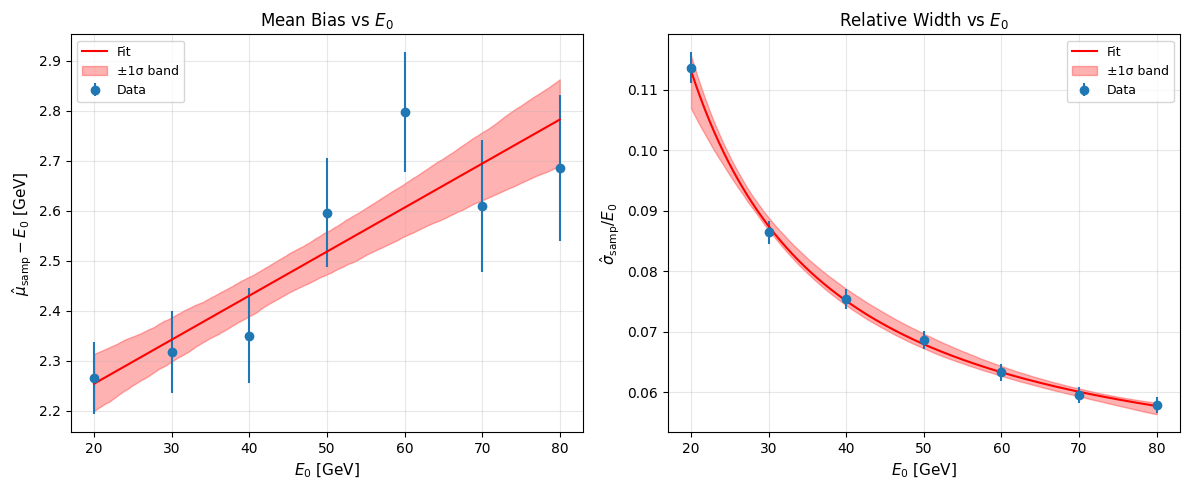

In [8]:
# 1. Compute sample stats
stats_df = compute_sample_stats(data_dict)

# 2. Fit models normally
lambda_samp, delta_samp, lambda_err_samp, delta_err_samp = fit_mean_model_least_squares(
    stats_df["E0"].values, stats_df["mean"].values, stats_df["mean_err"].values
)

a_samp, b_samp, c_samp, a_err_samp, b_err_samp, c_err_samp = fit_width_model_least_squares(
    stats_df["E0"].values, stats_df["std"].values, stats_df["std_err"].values
)

# 3. Bootstrap parameter uncertainties
lam_samples, delta_samples, a_samples, b_samples, c_samples = bootstrap_fit_results(
    stats_df["E0"].values,
    stats_df["mean"].values,
    stats_df["mean_err"].values,
    stats_df["std"].values,
    stats_df["std_err"].values,
    fit_mean_model_least_squares,
    fit_width_model_least_squares,
    n_boot=500
)

# 4. Produce Figure 1.4
plot_rescaled_with_fits_and_bands(
    stats_df,
    lambda_samp, delta_samp,
    a_samp, b_samp, c_samp,
    lam_samples, delta_samples,
    a_samples, b_samples, c_samples,
    savepath="figs/Figure1.4.pdf"
)


## 2) Individual Fits
**10 marks**

### 2(i) normal fits
- Now instead of sample estimates for the mean and width, perform and unbinned maximum likelihood fit of the distribution of $E$ at each value of $E_0$ using a normal distribution to determine the mean, $\hat{\mu}_{\rm indiv}$, and width, $\hat{\sigma}_{\rm indiv}$, (as well as their errors) at each $E_0$
- Make two plots (sub-axes of the same figure). The left should show the distribution of $E-E_0$ (with the distribution at each value of $E_0$ overlaid) also overlaying the result of the normal likelihood fits. The right should show the distribution of $E - E_0$ for all values and then overlay the approproiately normalised sum of sub-distributions. This plot should be saved in `figs/Figure2.1.pdf`

In [9]:
# Fit normal distribution at each energy point
indiv_fits_df = fit_individual_energies(data_dict)

print("Individual MLE Fits:")
print(indiv_fits_df.to_string(index=False))

Individual MLE Fits:
 E0        mu   mu_err    sigma  sigma_err
 20 22.264506 0.071843 2.271878   0.050800
 30 32.316381 0.081976 2.592320   0.057965
 40 42.350116 0.095331 3.014633   0.067409
 50 52.596214 0.108533 3.432122   0.076744
 60 62.796430 0.120060 3.796633   0.084895
 70 72.609270 0.131637 4.162732   0.093081
 80 82.685761 0.146518 4.633318   0.103604


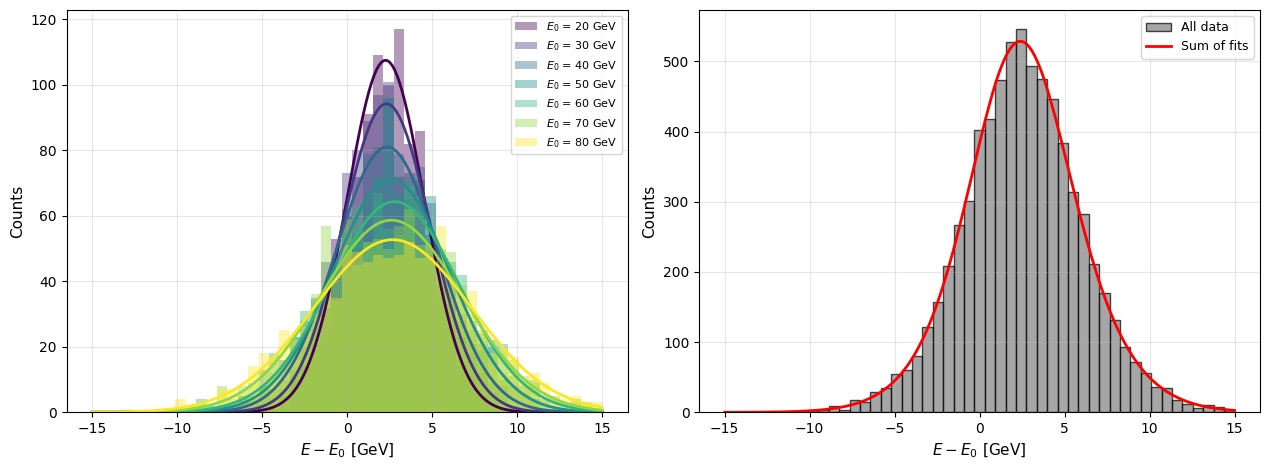

Figure 2.1 saved.


In [10]:
fig, ax = plot_individual_fits_overlaid(data_dict, indiv_fits_df, savepath='../figs/Figure2.1.pdf')
plt.show()
print("Figure 2.1 saved.")

### 2(ii) fit trends
- Perform a least squares fit using the energy and width dependence formulas provided in the problem description (at the top of this notebook) to produce estimates (and estimates of the errors on those estimates) for the parameters $\lambda$, $\Delta$, $a$, $b$ and $c$. Be sure to save these determinations for later or write them directly to the `results.json` file.
- Make two plots (sub-axes of the same figure) showing the fitted values $\hat{\mu}_{\rm indiv} - E_0$ and $\hat{\sigma}_{\rm indiv}/E_0$ as a function of $E_0$ **as well as** the fitted curves. You should add an error band ($\pm 1\sigma$) to the curves by bootstrapping. This figure should be saved to `figs/Figure2.2.pdf`

In [11]:
# Use the least squares functions on the individual fit results
lambda_indiv, delta_indiv, lambda_err_indiv, delta_err_indiv = fit_mean_model_least_squares(
    indiv_fits_df['E0'].values, indiv_fits_df['mu'].values, indiv_fits_df['mu_err'].values
)

a_indiv, b_indiv, c_indiv, a_err_indiv, b_err_indiv, c_err_indiv = fit_width_model_least_squares(
    indiv_fits_df['E0'].values, indiv_fits_df['sigma'].values, indiv_fits_df['sigma_err'].values
)

print(f"Individual Fits + Least Squares:")
print(f"λ = {lambda_indiv:.4f} ± {lambda_err_indiv:.4f}")
print(f"Δ = {delta_indiv:.4f} ± {delta_err_indiv:.4f}")
print(f"a = {a_indiv:.4f} ± {a_err_indiv:.4f}")
print(f"b = {b_indiv:.4f} ± {b_err_indiv:.4f}")
print(f"c = {c_indiv:.4f} ± {c_err_indiv:.4f}")

# Save to results
results.update('individual_fits',
               {'lb': lambda_indiv, 'dE': delta_indiv, 'a': a_indiv, 'b': b_indiv, 'c': c_indiv},
               {'lb': lambda_err_indiv, 'dE': delta_err_indiv, 'a': a_err_indiv, 'b': b_err_indiv, 'c': c_err_indiv})

Individual Fits + Least Squares:
λ = 1.0088 ± 0.0020
Δ = 2.0775 ± 0.0889
a = 0.2877 ± 0.0824
b = 1.6475 ± 0.2681
c = 0.0433 ± 0.0063


In [ ]:
# Bootstrap to get error bands
lam_bs, delta_bs, a_bs, b_bs, c_bs = bootstrap_fit_results(
    indiv_fits_df['E0'].values,
    indiv_fits_df['mu'].values,
    indiv_fits_df['mu_err'].values,
    indiv_fits_df['sigma'].values,
    indiv_fits_df['sigma_err'].values,
    fit_mean_model_least_squares,
    fit_width_model_least_squares,
    n_boot=500
)

# Plot with error bands
fig, ax = plot_rescaled_with_fits_and_bands(
    indiv_fits_df.rename(columns={'mu': 'mean', 'mu_err': 'mean_err', 'sigma': 'std', 'sigma_err': 'std_err'}),
    lambda_indiv, delta_indiv,
    a_indiv, b_indiv, c_indiv,
    lam_bs, delta_bs,
    a_bs, b_bs, c_bs,
    savepath='../figs/Figure2.2.pdf'
)
plt.show()
print("Figure 2.2 saved.")

## 3.) Simultaneous Fit
**10 marks**

### 3(i) the simultaneous likelihood
- Write down an equation for the simultaneous likelihood in which all points are fitted together, i.e. directly fitting the sample for $\lambda$, $\Delta$, $a$, $b$ and $c$
- Appropriately code this and perform an unbinned maximum likelihood fit to all $E_0$ bins simultaneously, to produce estimates (and estimates of the errors on those estimates) for the parameters $\lambda$, $\Delta$, $a$, $b$ and $c$. Be sure to save these determinations for later or write them directly to the `results.json` file.
- Make two plots (sub-axes of the same figure) showing the fitted curves for $\mu_E$ and $\sigma_E$ as a function of $E_0$. You should add an error band ($\pm 1\sigma$) to the curves by bootstrapping. You should stick to the convention of plotting $\mu_E - E_0$ and $\sigma_E / E_0$ as a function of $E_0$. This figure should be saved to `figs/Figure3.1.pdf`

The simultaneous likelihood:

$$\mathcal{L}(\lambda, \Delta, a, b, c) = \prod_{i=1}^{7} \prod_{j=1}^{1000} \frac{1}{\sqrt{2\pi}\sigma_E(E_{0,i})} \exp\left[-\frac{(E_{ij} - \mu_E(E_{0,i}))^2}{2\sigma_E^2(E_{0,i})}\right]$$

where $\mu_E(E_0) = \lambda E_0 + \Delta$ and $\sigma_E(E_0) = E_0 \sqrt{(a/\sqrt{E_0})^2 + (b/E_0)^2 + c^2}$.

In [13]:
# Perform simultaneous fit
params_simul, errors_simul, minuit_obj = fit_simultaneous_all_energies(data_dict)

print("Simultaneous Fit Results:")
print(f"λ = {params_simul['lam']:.4f} ± {errors_simul['lam']:.4f}")
print(f"Δ = {params_simul['delta']:.4f} ± {errors_simul['delta']:.4f}")
print(f"a = {params_simul['a']:.4f} ± {errors_simul['a']:.4f}")
print(f"b = {params_simul['b']:.4f} ± {errors_simul['b']:.4f}")
print(f"c = {params_simul['c']:.4f} ± {errors_simul['c']:.4f}")
print(f"\nFit valid: {minuit_obj.valid}")
print(f"Fit accurate: {minuit_obj.accurate}")

Simultaneous Fit Results:
λ = 1.0088 ± 0.0020
Δ = 2.0773 ± 0.0889
a = 0.2888 ± 0.0607
b = 1.6442 ± 0.2019
c = 0.0432 ± 0.0047

Fit valid: True
Fit accurate: True


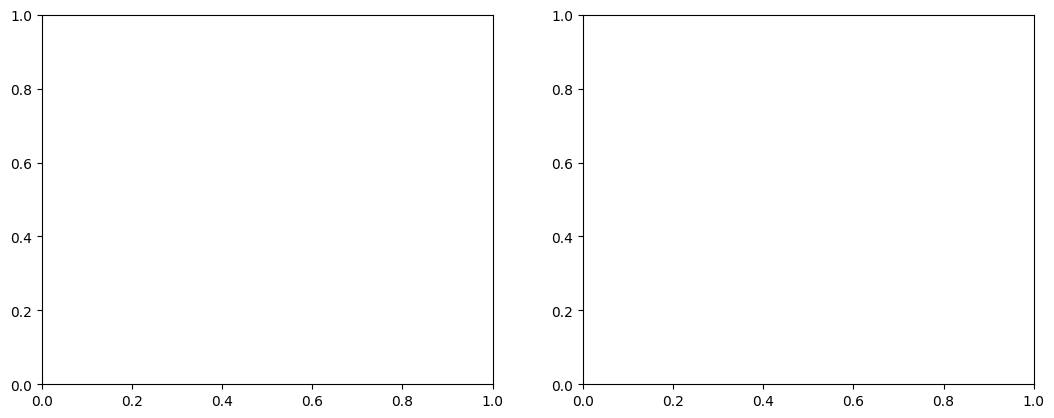

Figure 3.1 saved.


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

# TODO: Add fitted curves with bootstrap error bands

fig.savefig('../figs/Figure3.1.pdf')
plt.show()

print("Figure 3.1 saved.")

### 3(ii) saving the results
- At this point you should have estimates of the five parameters, $\{\lambda, \Delta, a, b, c\}$, (along with their errors), using three different methods: "a sample estimate", "individual fits" and "a simultaneous fit".
- Ensure these are now saved into the `results.json` file in the correct format

In [15]:
# Update results with simultaneous fit
results.update('simultaneous_fit',
               {'lb': params_simul['lam'], 'dE': params_simul['delta'],
                'a': params_simul['a'], 'b': params_simul['b'], 'c': params_simul['c']},
               {'lb': errors_simul['lam'], 'dE': errors_simul['delta'],
                'a': errors_simul['a'], 'b': errors_simul['b'], 'c': errors_simul['c']})

# Save results.json
results.save('../results.json')

# Display results
results.display()

Results saved to ../results.json
{
  "sample_ests": {
    "values": {
      "lb": 1.0088081685779529,
      "dE": 2.077543484031809,
      "a": 0.2877230044874781,
      "b": 1.648826668898582,
      "c": 0.0432881052743988
    },
    "errors": {
      "lb": 0.0019821462805771624,
      "dE": 0.0888953823744793,
      "a": 0.08120179402367339,
      "b": 0.2644172665146701,
      "c": 0.00617634334570788
    }
  },
  "individual_fits": {
    "values": {
      "lb": 1.0088081686985897,
      "dE": 2.077543478805693,
      "a": 0.28767527270155463,
      "b": 1.6475034366797796,
      "c": 0.043258423652815126
    },
    "errors": {
      "lb": 0.001981155156396922,
      "dE": 0.08885092927006277,
      "a": 0.08235332913774357,
      "b": 0.26814273067112937,
      "c": 0.006264208889444921
    }
  },
  "simultaneous_fit": {
    "values": {
      "lb": 1.008821966878712,
      "dE": 2.077348424562566,
      "a": 0.2888241506981083,
      "b": 1.6442051360806127,
      "c": 0.0432225870

### 3(iii) comparing the results
- Make a plot which shows the estimate and error of each parameter, labelling the different estimation types with different colours.
- The parameters may well have rather different values so you will need to think carefully about how you present this information in a sensible way.
- You should save this in a file called `figs/Figure3.2.pdf`

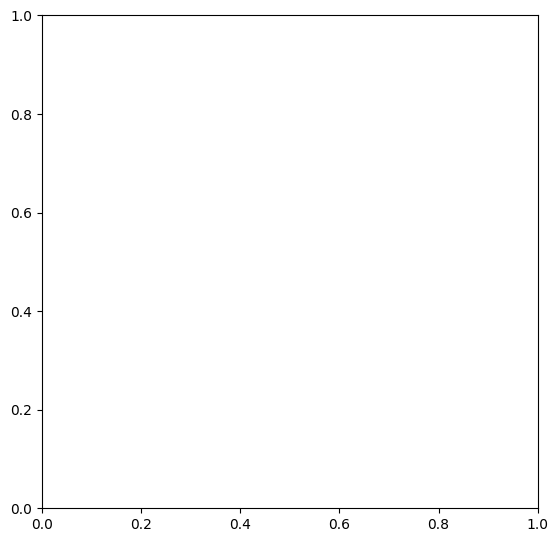

Figure 3.2 saved.


In [16]:
fig, ax = plt.subplots(figsize=(6.4, 6.4))

# TODO: Add comparison plot of all three methods

fig.savefig('../figs/Figure3.2.pdf')
plt.show()

print("Figure 3.2 saved.")

## 4.) Bootstrap entire sample
**20 marks**
- Run a non-parameteric bootstrap on the entire analysis using sampling with replacement (and 2500 samples). For reference on my machine this takes ~1 min)
- Produce a figure with 5 subfigures which shows histograms of the bootstrapped values with each method overlaid as a separate colour. You should save this plot in a file called `figs/Figure4.1.pdf`
- Produce a second figure which is the same in style to the plot produced in 3(iii) above this time using the bootstrapped sample to estimate the value and error. You should overlay both sets of points (i.e. the values and errors from parts 1-3 and also the bootstrapped values and errors from part 4). You should save this plot in a file called `figs/Figure4.2.pdf`

In [17]:
# TODO: Implement bootstrap analysis

# def analysis_function(bootstrap_data):
#     # Run all three methods on bootstrap sample
#     # Return dict with all parameters
#     pass

# bootstrap_results = run_bootstrap_analysis(data_dict, analysis_function, n_bootstrap=2500)

print("TODO: Implement bootstrap analysis")

TODO: Implement bootstrap analysis


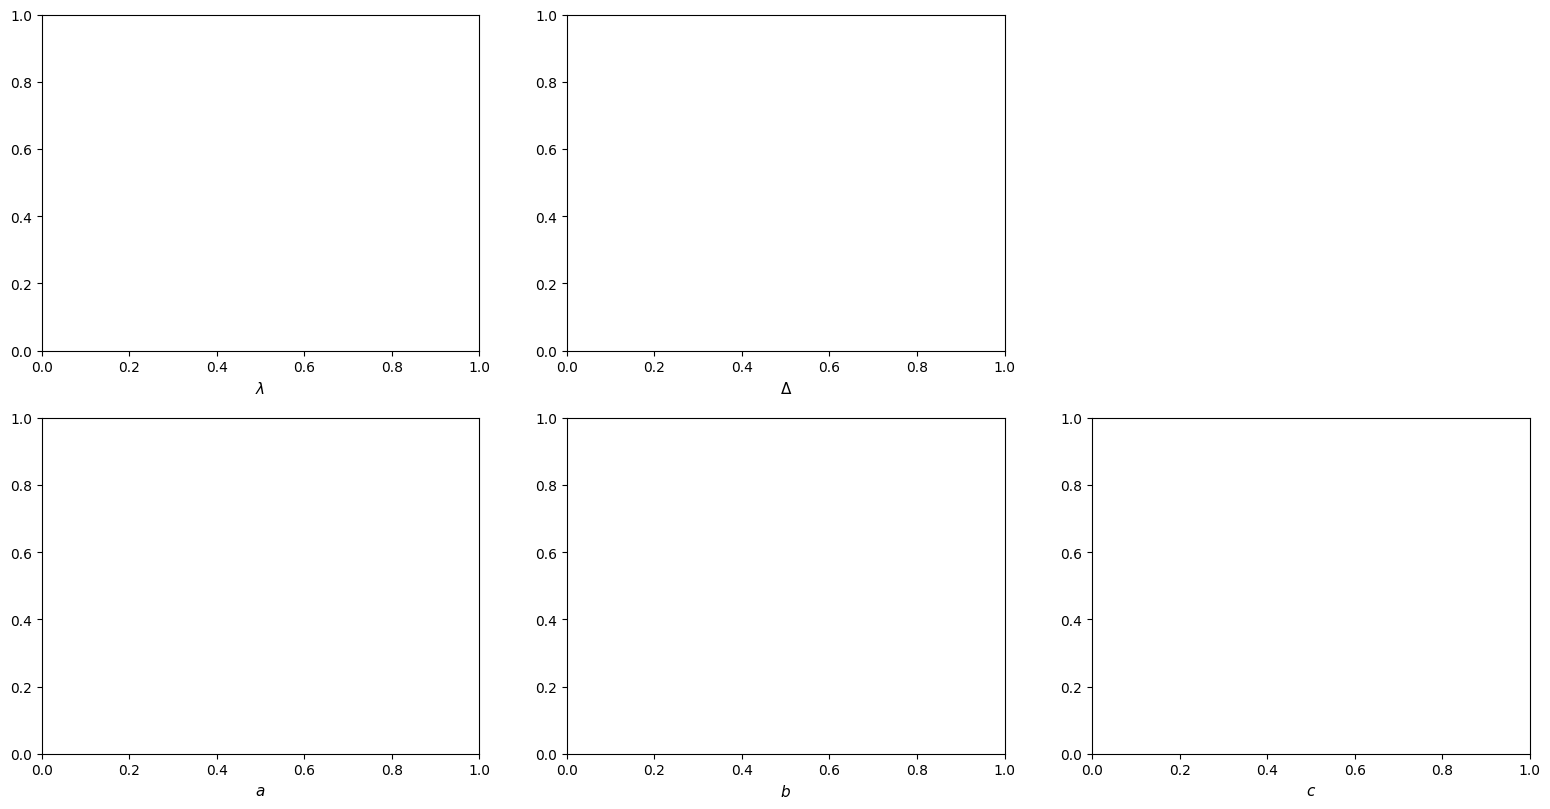

Figure 4.1 saved.


In [18]:
fig, ax = plt.subplots(2, 3, figsize=(19.2, 9.6))

# TODO: Add bootstrap histograms

ax[0,0].set_xlabel("$\\lambda$")
ax[0,1].set_xlabel("$\\Delta$")
ax[0,2].set_visible(False)
ax[1,0].set_xlabel("$a$")
ax[1,1].set_xlabel("$b$")
ax[1,2].set_xlabel("$c$")

fig.savefig('../figs/Figure4.1.pdf')
plt.show()

print("Figure 4.1 saved.")

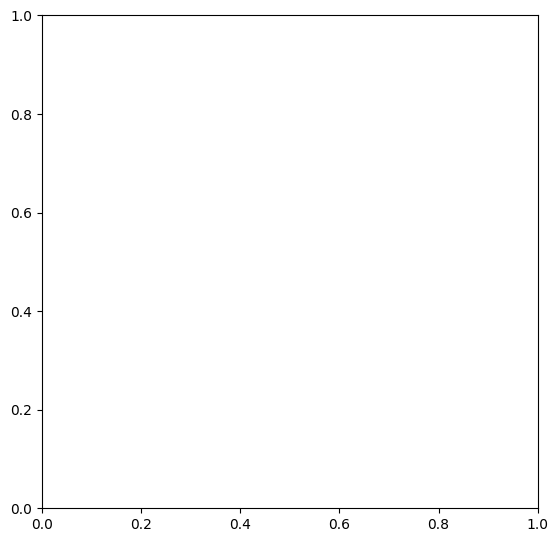

Figure 4.2 saved.


In [19]:
fig, ax = plt.subplots(figsize=(6.4, 6.4))

# TODO: Add comparison plot with both original and bootstrap uncertainties

fig.savefig('../figs/Figure4.2.pdf')
plt.show()

print("Figure 4.2 saved.")

## 5.) Discussion of Results
**20 marks**

- Please briefly discuss your findings in no more than 500 words. Do you find what you would naively expect? Can you comment on any discrepancies you see? Would you redesign the analysis in any way?

TODO: Add your discussion here (maximum 500 words)